# PalmPrint Recognition

For this part, we will develop a **Conctact Less Palm recognition system**. The dataset we will use is available at [this website](https://cslinzhang.github.io/ContactlessPalm/?fbclid=IwAR27ef6k9NEFq-bAkQVV63rRy-PZM0P7uQdCrwWIQjO2JBABT3jql48Hk9k). Note that the authors have published 2 different datasets : one *original* dataset for raw images, one *roi* dataset for images where the palm have been detected and the different palms have been aligned. For the sake of simplicity, we will do our system based on the *roi* dataset. For the ones interested on how to extract the *roi* from the *raw* images, the authors have given a comprehensive explanation in [their paper](https://cslinzhang.github.io/ContactlessPalm/contactlesspalm.pdf).

We will also use some of the functions that were used for the fingeprint and iris part of this assignment.

#### First, let's get the dataset

The ROI dataset can be downloaded on [drive](https://drive.google.com/file/d/1KZCXi6zAk5mZ1nQHFdeYHboAII3DOjls/view). There are 2 subfolders : session 1 and session 2, corresponding to 2 sessions of measurements. Each subfolder contain 6000 images corresponding to 600 different palms : 

- images id from 00001.bmp to 00010.bmp correspond to identity 1
- images id from 00011.bmp to 00020.bmp correspond to identity 2
- images id from 00021.bmp to 00030.bmp correspond to identity 3
- ...
- images id from 05991.bmp to 06000.bmp correspond to identity 600


Due to limited computation capacity, we will not use the whole dataset, but only the first 100 identities (images from 00001.bmp to 01000.bmp). We will use data from the 2 sessions. So at the end, our dataset can be defined as : 

- having 100 identities
- each identity has 10 images from each session, so each identity has 20 images
- the total size of the dataset is 2000

In [14]:
#to plot figures inline
%matplotlib inline
# OpenCV package
import cv2
# Standard array processing package
import numpy as np
# Plotting library
from matplotlib import pyplot as plt
# Setting the default colormap for pyplot
import matplotlib as mpl
mpl.rc('image', cmap='gray')
# File path processing package
from pathlib import Path
from sklearn.metrics import roc_curve
# Pickle allows to save and read intermediate results (similar to save and load in Matlab)
import pickle
# Allows us to generate markdown using python code
from IPython.display import Markdown
# Data analysis and manipulation tool
import pandas as pd
# Cartesian product of 2 iterables
from itertools import product
# Path name pattern searching
import glob
# OS interfaces
import os
# Compression interface
import zlib
# Binary encoding
from base64 import urlsafe_b64encode as b64e, urlsafe_b64decode as b64d

from sklearn import metrics
import seaborn as sns

from scipy.spatial import distance

# Your imports here (if any)
# import ...


In [15]:
def read_DB_palm(path):
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.bmp"))
    for imagePath in (imagePaths):
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        #label rule :
            #identity 1 if image name from 00001.bmp to 00010.bmp 
            #identity 2 if image name from 00011.bmp to 00020.bmp
        label = (int(imagePath.stem)-1)//10
        labels.append(label)
    return (images, labels)
    

# Read the fingerprint database of session 1 
images_db_palm, labels_db_palm = read_DB_palm('palmprint/data/session1/')
images_db_palm = images_db_palm[:1000]
labels_db_palm = labels_db_palm[:1000]


# Read the fingerprint database of session 2
images_db_palm_2, labels_db_palm_2 = read_DB_palm('palmprint/data/session2/')
images_db_palm_2 = images_db_palm_2[:1000]
labels_db_palm_2 = labels_db_palm_2[:1000]


#concatenate the 2 sessions
images_db_palm = images_db_palm + images_db_palm_2
labels_db_palm = labels_db_palm + labels_db_palm_2

# Save some metadata
n_imgs = len(images_db_palm)
img_height, img_width = images_db_palm[0].shape

Markdown(f"""Here are some samples from the database, which contains {n_imgs} images of size {img_height}x{img_width}. Remember, visualization is always a good idea, so let's visualize some""")

Here are some samples from the database, which contains 2000 images of size 128x128. Remember, visualization is always a good idea, so let's visualize some

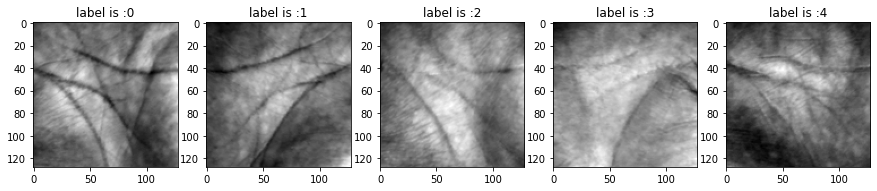

In [16]:
i = 3

f,ax = plt.subplots(1,5, figsize=(15,10))

for j in range (0,5):
    ax[j].imshow(images_db_palm[i+j*10], cmap='gray')
    ax[j].set_title("label is :" + str(labels_db_palm[i+j*10]))
plt.show()

#### What are the features in a palmprint ?

As in fingerprint with edges, valleys, minutiae etc, palmprint has also unique features among individuals. 

The features are .....


see paper https://link.springer.com/referenceworkentry/10.1007/978-0-387-73003-5_266

#### Feature extraction

Which features are we going to use to recognize the palmprints ? Different method exist, inspire by IrisCod of Daugman. The most popular methods for palmprint recognition  are [PalmCode](https://ieeexplore.ieee.org/document/1410434), [CompCode](https://ieeexplore.ieee.org/abstract/document/1334184). Other more classical feature extraction methods such as [SIFT](https://ieeexplore.ieee.org/document/5634472) have also been used. In general, authors use SIFT features to fuse the scores of their method with the scores of the SIFT features to have a more robust system.

Because I already have try SIFT features etc on the first part of this assignment, I wanted to do something different : Deep Learning based approaches. CNN with triplet loss have already been applied successfully on palm print recognition (see [paper](https://ieeexplore.ieee.org/document/8963760)). 

We will use the [Triplet loss implementation](https://www.tensorflow.org/addons/tutorials/losses_triplet) of Tensorflow. We will also use some part of the implementation of [Adrian-Stefan Ungureanu
](https://github.com/AdrianUng/keras-triplet-loss-mnist)

#### Prepare the data for Tensorflow

Instead of working with a list of arrays, let's work with a 3D array of dimensions (number_samples, img_width, img_height)



In [17]:
import numpy as np


df_palm = np.stack(images_db_palm)
labels_palm = np.array(labels_db_palm)

print(df_palm.shape, labels_palm.shape)

(2000, 128, 128) (2000,)


In [18]:
print(df_palm)

[[[ 70  70  71 ...  86  88  90]
  [ 70  70  70 ...  89  91  90]
  [ 69  69  71 ...  91  91  90]
  ...
  [ 76  77  77 ...  77  80  82]
  [ 75  77  77 ...  77  79  81]
  [ 79  79  78 ...  77  79  81]]

 [[ 73  72  73 ...  93  93  94]
  [ 73  73  73 ...  95  95  95]
  [ 71  73  74 ...  95  96  98]
  ...
  [ 77  77  78 ...  79  80  82]
  [ 73  75  76 ...  79  79  82]
  [ 74  76  75 ...  77  78  80]]

 [[ 78  78  78 ...  91  93  93]
  [ 77  77  78 ...  92  93  94]
  [ 76  77  79 ...  94  94  96]
  ...
  [ 85  86  86 ...  84  84  86]
  [ 85  85  86 ...  84  85  87]
  [ 85  88  89 ...  82  83  86]]

 ...

 [[131 131 130 ... 112 112 107]
  [133 133 134 ... 114 114 113]
  [133 134 137 ... 119 116 115]
  ...
  [161 161 161 ... 162 154 153]
  [162 161 161 ... 164 159 156]
  [162 160 159 ... 166 164 158]]

 [[ 90  90  92 ... 103  98  94]
  [ 91  92  91 ... 106 103  97]
  [ 90  92  91 ... 106 106 102]
  ...
  [139 138 137 ... 171 168 166]
  [137 136 134 ... 169 167 166]
  [132 132 131 ... 165 162 1

Let's also divide the data into train and validation

In [19]:
from sklearn.model_selection import train_test_split

df_palm = df_palm/255

x_train, x_val, y_train, y_val = train_test_split(df_palm, labels_palm, test_size=0.25, random_state=42,stratify = labels_palm)

In [20]:
x_train

array([[[0.29803922, 0.30196078, 0.30588235, ..., 0.36862745,
         0.36470588, 0.37254902],
        [0.30196078, 0.30980392, 0.30980392, ..., 0.36470588,
         0.36470588, 0.36862745],
        [0.30980392, 0.31372549, 0.31764706, ..., 0.36862745,
         0.36862745, 0.37254902],
        ...,
        [0.42352941, 0.43529412, 0.43921569, ..., 0.56862745,
         0.58039216, 0.58823529],
        [0.41176471, 0.41960784, 0.43529412, ..., 0.56862745,
         0.58039216, 0.58431373],
        [0.40392157, 0.41568627, 0.43137255, ..., 0.57647059,
         0.59607843, 0.59607843]],

       [[0.30196078, 0.29803922, 0.29803922, ..., 0.44313725,
         0.44313725, 0.43921569],
        [0.30588235, 0.30980392, 0.30980392, ..., 0.45098039,
         0.44705882, 0.44705882],
        [0.31764706, 0.31372549, 0.30588235, ..., 0.45882353,
         0.45490196, 0.45098039],
        ...,
        [0.38039216, 0.38431373, 0.39215686, ..., 0.80392157,
         0.80392157, 0.80392157],
        [0.3

#### Definition of the network

The network should be able to learn embeddings of the images in a robust way : translation, rotation (even if the images have been aligned), illumination changes should not have a big impact on the embedding created from the network.
Thus, using CNN is well suited.

The CNN will output a feature vector representing the image, called **embedding**. The purpose of using *Triplet Loss* is to have well separated emebedding between different classes.

In [21]:
from tensorflow.keras.layers import Dense, Flatten,Dropout, Conv2D, MaxPool2D,BatchNormalization,Input,concatenate
import tensorflow.keras as keras
import tensorflow as tf

image_input_shape = (img_height,img_height,1)
embedding_size = 100

def cnn(image_input_shape, embedding_size):
    
    input_image = Input(shape=image_input_shape)
    x = Conv2D(32,5, activation='relu')(input_image)
    x = MaxPool2D(2)(x)
    x = Conv2D(64,5, activation='relu')(x)
    x = MaxPool2D(2)(x)
    x = Conv2D(128,3, activation='relu')(x)
    x = MaxPool2D(2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(embedding_size)(x)
    
    cnn = keras.Model(inputs=input_image, outputs=x)
    
    return cnn

In [22]:
## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.
    labels = y_pred[:, :1]

 
    labels = tf.cast(labels, dtype='int32')

    embeddings = y_pred[:, 1:]

    ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
    
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    # lshape=array_ops.shape(labels)
    # assert lshape.shape == 1
    # labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    # global batch_size  
    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')
    
    ### Code from Tensorflow function semi-hard triplet loss ENDS here.
    return semi_hard_triplet_loss_distance

In [23]:
from tensorflow.keras import Model

base_network = cnn(image_input_shape, embedding_size)

input_images = Input(shape=image_input_shape, name='input_image') # input layer for images
input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
embeddings = base_network([input_images])               # output of network -> embeddings
labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

# Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
model = Model(inputs=[input_images, input_labels],
            outputs=labels_plus_embeddings)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

#ps : we have to choose a quite high batch size to the number of classes (we have 100 classes)
#the batch size should be at least higher than 100 to avoid nan losses

opt = Adam()  # choose optimiser. RMS is good too!
model.compile(loss=triplet_loss_adapted_from_tf, 
              optimizer=opt)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',      
                            factor=0.7,
                            patience=10,
                            verbose=1)

#save best weights
checkpoint = ModelCheckpoint(filepath = 'model/checkpoint_best', 
                    monitor='val_loss',           
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)



# Uses 'dummy' embeddings + dummy gt labels; removed as soon as they enter the loss function...
dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))

H = model.fit(x=[x_train,y_train],
            y=dummy_gt_train,
            batch_size=300,
            epochs=150,
            validation_data=([x_val, y_val], dummy_gt_val),
            callbacks = [reduce_lr,checkpoint])

Epoch 1/150
5/5 [==============================] - 3s 432ms/step - loss: 0.8775 - val_loss: 0.7320

Epoch 00001: val_loss improved from inf to 0.73196, saving model to model\checkpoint_best
Epoch 2/150
5/5 [==============================] - 2s 399ms/step - loss: 0.3620 - val_loss: 0.6380

Epoch 00002: val_loss improved from 0.73196 to 0.63803, saving model to model\checkpoint_best
Epoch 3/150
5/5 [==============================] - 2s 398ms/step - loss: 0.4073 - val_loss: 0.9750

Epoch 00003: val_loss did not improve from 0.63803
Epoch 4/150
5/5 [==============================] - 2s 399ms/step - loss: 0.9807 - val_loss: 0.9984

Epoch 00004: val_loss did not improve from 0.63803
Epoch 5/150
5/5 [==============================] - 2s 398ms/step - loss: 0.9936 - val_loss: 0.9922

Epoch 00005: val_loss did not improve from 0.63803
Epoch 6/150
5/5 [==============================] - 2s 398ms/step - loss: 0.9877 - val_loss: 0.9903

Epoch 00006: val_loss did not improve from 0.63803
Epoch 7/150



Epoch 00050: val_loss did not improve from 0.32913
Epoch 51/150
5/5 [==============================] - 2s 404ms/step - loss: 0.4154 - val_loss: 0.3429

Epoch 00051: val_loss did not improve from 0.32913
Epoch 52/150
5/5 [==============================] - 2s 405ms/step - loss: 0.3995 - val_loss: 0.3309

Epoch 00052: val_loss did not improve from 0.32913
Epoch 53/150
5/5 [==============================] - 2s 403ms/step - loss: 0.4264 - val_loss: 0.3583

Epoch 00053: val_loss did not improve from 0.32913
Epoch 54/150
5/5 [==============================] - 2s 403ms/step - loss: 0.4253 - val_loss: 0.3896

Epoch 00054: val_loss did not improve from 0.32913
Epoch 55/150
5/5 [==============================] - 2s 404ms/step - loss: 0.4378 - val_loss: 0.4082

Epoch 00055: val_loss did not improve from 0.32913
Epoch 56/150
5/5 [==============================] - 2s 404ms/step - loss: 0.4863 - val_loss: 0.3952

Epoch 00056: val_loss did not improve from 0.32913
Epoch 57/150
5/5 [==================

5/5 [==============================] - 2s 404ms/step - loss: 0.3675 - val_loss: 0.1897

Epoch 00101: val_loss improved from 0.20588 to 0.18965, saving model to model\checkpoint_best
Epoch 102/150
5/5 [==============================] - 2s 405ms/step - loss: 0.3462 - val_loss: 0.1891

Epoch 00102: val_loss improved from 0.18965 to 0.18915, saving model to model\checkpoint_best
Epoch 103/150
5/5 [==============================] - 2s 405ms/step - loss: 0.3651 - val_loss: 0.1906

Epoch 00103: val_loss did not improve from 0.18915
Epoch 104/150
5/5 [==============================] - 2s 404ms/step - loss: 0.3501 - val_loss: 0.2037

Epoch 00104: val_loss did not improve from 0.18915
Epoch 105/150
5/5 [==============================] - 2s 406ms/step - loss: 0.3628 - val_loss: 0.1892

Epoch 00105: val_loss did not improve from 0.18915
Epoch 106/150
5/5 [==============================] - 2s 405ms/step - loss: 0.3454 - val_loss: 0.1824

Epoch 00106: val_loss improved from 0.18915 to 0.18235, savin

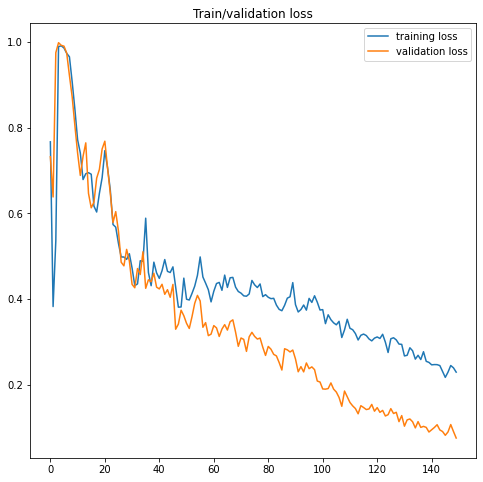

In [25]:
plt.figure(figsize=(8,8))
plt.plot(H.history['loss'], label='training loss')
plt.plot(H.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Train/validation loss')
plt.show()

We can make different observations from the curves :

- The losses are very unstable at the first epochs. However, this should not alarm us : it just means that the landscape of the loss function, at the initialized weights, is very steep, and the initial learning rate is too big compared to that.
- The validation loss is lower than the training accuracy : it can be explained from the fact that the validation samples are easier to separate well compared to the training ones

In [26]:
    # Test the network

# creating an empty network
testing_embeddings = cnn(image_input_shape,
                                         embedding_size=embedding_size)
x_embeddings_before_train = testing_embeddings.predict(np.reshape(x_val, (len(x_val), img_width, img_height, 1)))
# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
        weights = layer_source.get_weights()
        layer_target.set_weights(weights)
        del weights

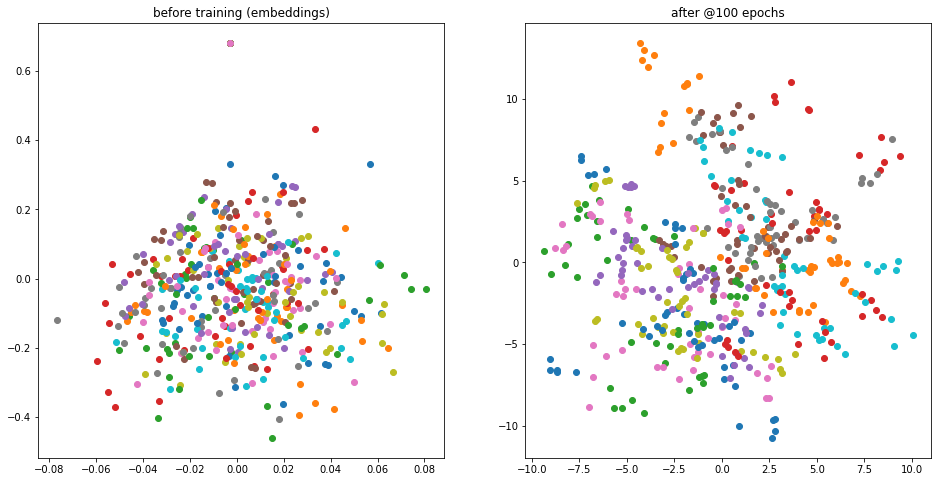

In [27]:
# Visualizing the effect of embeddings -> using PCA!

from sklearn.decomposition import PCA


x_embeddings = testing_embeddings.predict(np.reshape(x_val, (len(x_val), img_width, img_height, 1)))
dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(y_val))

pca = PCA(n_components=2)
decomposed_embeddings = pca.fit_transform(x_embeddings)
decomposed_gray = pca.fit_transform(x_embeddings_before_train)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    step = 1
    decomposed_embeddings_class = decomposed_embeddings[y_val == label]
    decomposed_gray_class = decomposed_gray[y_val == label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % 100)

plt.show()  

Even if the class are not well separable after 100 epoch, we can still see some clusters. 

Let's also keep in mind that we visualize the data in 2 dimensions, and we will apply non-linear classifier it.

To be really able to see if having the embeddings with triplet loss, let's compare the performance of an SVM on the data before applying our *triplet loss pipeline* and the performance of an SVM on the embedding obtained with the triplet loss.

In [28]:
from sklearn import svm

In [29]:
clf = svm.SVC()


x_train_to_train = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_val_to_train = x_val.reshape((x_val.shape[0],x_val.shape[1]*x_val.shape[2]))

clf.fit(x_train_to_train,y_train)

SVC()

In [30]:
#Predict the response for test dataset
y_pred = clf.predict(x_val_to_train)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.894


After finding the embedding : 

In [31]:
x_embeddings_train = testing_embeddings.predict(np.reshape(x_train, (len(x_train), img_width, img_height, 1)))
x_embeddings_val = testing_embeddings.predict(np.reshape(x_val, (len(x_val), img_width, img_height, 1)))


In [32]:
clf = svm.SVC(probability=True)


clf.fit(x_embeddings_train,y_train)


#Predict the response for test dataset
y_pred = clf.predict(x_embeddings_val)
pred = clf.predict_proba(x_embeddings_val)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.962


We can clearly see that our pipeline helps.

However, let's keep in mind that we are in a Biometrics Course. Accuracy is not a well-suited metric in an identification scenario. Let's now measure the performance of our pipeline with several methods we have defined in the first assignment.

In the variable "*pred*", we have saved the prediction of the models for all the classes for each input label. We have 500 tests samples, with a dataset of 100 classes. So, the "*pred*" array has shape (500, 100).

For example, for the first input test sample, we will have an array of probabilities for each of the 100 classes. This will allow us to plot the CMC curve for example.

In [33]:
pred.shape

(500, 100)

In [34]:
pred[0]

array([0.00406227, 0.00434481, 0.0049813 , 0.01535232, 0.00347517,
       0.00448868, 0.00477805, 0.00789426, 0.00398894, 0.01699974,
       0.00485461, 0.00426263, 0.00417447, 0.20844003, 0.00342496,
       0.00353012, 0.00382228, 0.00527775, 0.004932  , 0.00683844,
       0.00390232, 0.009887  , 0.00425783, 0.00925498, 0.00882106,
       0.01176066, 0.00369491, 0.00791795, 0.00434901, 0.00696003,
       0.0034599 , 0.01624058, 0.00359712, 0.05194446, 0.00349584,
       0.00551491, 0.00320406, 0.00589748, 0.0032568 , 0.00696083,
       0.00510549, 0.00422885, 0.00344737, 0.00543409, 0.00343726,
       0.00650241, 0.00524217, 0.00821516, 0.00517991, 0.00662668,
       0.00376317, 0.01985759, 0.00988885, 0.00721001, 0.00892714,
       0.02348574, 0.00344279, 0.02755124, 0.0039217 , 0.0222997 ,
       0.00385989, 0.00707364, 0.01117231, 0.01189961, 0.00475686,
       0.00511117, 0.00396291, 0.00960294, 0.00323239, 0.00550444,
       0.00663151, 0.00602696, 0.00348118, 0.00613171, 0.00374

Let's get the top accuracy to be able to plot the CMC. First let's sort the prediction in descending order.


In [35]:
predictions = pd.DataFrame(pred)
predictions

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.004062,0.004345,0.004981,0.015352,0.003475,0.004489,0.004778,0.007894,0.003989,0.017000,...,0.003751,0.017911,0.003502,0.004438,0.005448,0.025933,0.016375,0.028286,0.004835,0.017840
1,0.003841,0.004463,0.003545,0.004066,0.003974,0.004229,0.005217,0.005604,0.006760,0.005734,...,0.003536,0.017265,0.003623,0.033271,0.004314,0.004291,0.003285,0.005098,0.003061,0.008694
2,0.003347,0.002961,0.008500,0.004806,0.002511,0.005298,0.019234,0.005299,0.005029,0.003434,...,0.003033,0.003825,0.004505,0.003542,0.029782,0.013825,0.011160,0.009797,0.018317,0.003712
3,0.002802,0.002598,0.003062,0.002518,0.002516,0.007775,0.013422,0.006285,0.002865,0.002433,...,0.004367,0.002475,0.103789,0.004115,0.025975,0.002925,0.002873,0.002448,0.003830,0.002593
4,0.002731,0.002332,0.005667,0.002969,0.002326,0.010006,0.031110,0.007426,0.003887,0.002204,...,0.003613,0.002589,0.011423,0.002905,0.032803,0.005012,0.005413,0.002802,0.012509,0.002275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.006821,0.003875,0.007575,0.003307,0.004685,0.005780,0.020401,0.003693,0.006920,0.003186,...,0.036106,0.003036,0.014004,0.003469,0.006352,0.004192,0.003664,0.003261,0.008499,0.003109
496,0.014423,0.005829,0.010155,0.004301,0.009429,0.006499,0.012199,0.004240,0.016288,0.004047,...,0.015255,0.003922,0.008213,0.004306,0.004772,0.005416,0.004660,0.004167,0.011084,0.003823
497,0.005454,0.004896,0.005469,0.004724,0.004643,0.004846,0.013482,0.004669,0.005102,0.004621,...,0.029862,0.004691,0.033267,0.005774,0.010747,0.005082,0.004557,0.004619,0.005358,0.004582
498,0.003295,0.003201,0.003113,0.003466,0.003023,0.004669,0.004375,0.008412,0.003984,0.003621,...,0.003131,0.020258,0.003754,0.041926,0.005093,0.003673,0.003257,0.003804,0.002851,0.011151


In [36]:
maxValueIndex = predictions.idxmax(axis = 1)
print(maxValueIndex)

0      13
1      17
2      62
3      92
4      58
       ..
495    68
496    72
497    32
498    79
499    60
Length: 500, dtype: int64


In [37]:
predictions.shape[0]

500

In [38]:
#dataframe of recognized or not : if recognized, value = 1. Else, value = 0 
#the columnn is for the rank : from 0 to 1
#the row is for the particular subject_id
#so, for example, if at row 1 and rank 1, the value is 1, it means that it has been recognized
recognized_df = pd.DataFrame()

#first for loop to get through all row
#second for loop to test for rank from 1 to 100
for i in range(0,predictions.shape[0]):
    #we sort the row "i", from higher score to lower
    predictions_sorted = predictions.iloc[i].to_frame().sort_values(
    by=list(predictions.iloc[i].to_frame().columns),axis=0,ascending=False).transpose()
    #we save the actual label
    subject_id = y_val[i]
    #this list if for the "j" id with highest similarities 
    highest_similarities_id  = []
    for j in range(1,101):
        #for each "j", we append the highest similarity id
        #this list will then accumulates as "j" grows
        highest_similarities_id.append(predictions_sorted.columns[j-1])
        #if the subject id is in the list, we set the value of the corresponding dataframe cell to 1
        if subject_id in highest_similarities_id:
            recognized_df.at[i,j] =  1
        else:
            recognized_df.at[i,j] =  0

#we can now sum over all rows (subject_id)
#by dividing by matrix_length, we should get the recognition rate
recognition_rate = recognized_df.sum(axis=0)/predictions.shape[0]
print(recognition_rate)


1      0.960
2      0.984
3      0.992
4      0.994
5      0.994
       ...  
96     1.000
97     1.000
98     1.000
99     1.000
100    1.000
Length: 100, dtype: float64


Text(0, 0.5, 'Recognition Rate')

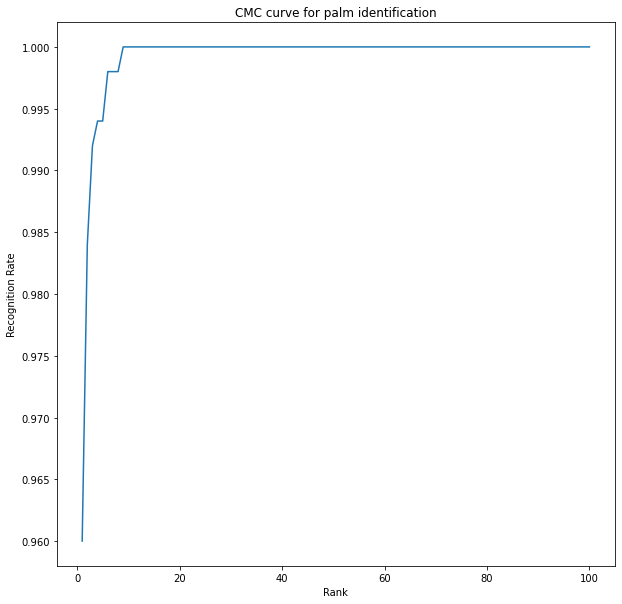

In [39]:
fig, axis = plt.subplots(1,1,figsize=(10,10))
axis.plot(np.arange(1, 101), recognition_rate)
axis.title.set_text("CMC curve for palm identification") 
axis.set_xlabel('Rank')
axis.set_ylabel('Recognition Rate')


In [40]:
from beautifultable import BeautifulTable


rank_1_recognition_rate = recognition_rate[1]


table = BeautifulTable()
table.rows.append([rank_1_recognition_rate])
table.rows.header = ["Palmprint"]
table.columns.header = ["Rank 1 recognition rate"]
print(table)

+-----------+-------------------------+
|           | Rank 1 recognition rate |
+-----------+-------------------------+
| Palmprint |          0.96           |
+-----------+-------------------------+
